In [1]:
from oggm import cfg, workflow, utils, shop
import pandas as pd
import os, glob
import numpy as np
from scipy import stats
import xarray as xr
import matplotlib.pyplot as plt
import progressbar

In [2]:
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
gcms = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)
gcms = list(gcms.gcm.unique())
gcms

['CESM2-WACCM',
 'MPI-ESM1-2-HR',
 'GFDL-ESM4',
 'NorESM2-MM',
 'INM-CM4-8',
 'INM-CM5-0',
 'MRI-ESM2-0',
 'CESM2',
 'EC-Earth3',
 'EC-Earth3-Veg',
 'CAMS-CSM1-0',
 'BCC-CSM2-MR',
 'FGOALS-f3-L',
 'TaiESM1',
 'CMCC-CM2-SR5']

In [4]:
idir = 'era5_eb_nocalv_run/cmip6_output/'

## Find the subset of glaciers that never failed - in the 2300 runs and 2100 runs (short) 

In [6]:
failed = set()
failed_short = set()
fdf = pd.DataFrame()
for rgi_reg in range(1, 20):
    rgi_reg = '{:02d}'.format(rgi_reg)
    print(rgi_reg)
    rdir = idir + 'RGI' + rgi_reg + '/'
    all_ncs = glob.glob(rdir + '*/*.nc')
    for nc in sorted(all_ncs):
        ssp = os.path.basename(nc).split('_')[1].replace('.nc', '')
        gcm = os.path.basename(nc).split('_')[0]
        key_both = ssp + '_' + gcm
        with xr.open_dataset(nc) as ds:
            this_failed = ds.rgi_id[ds.volume.isel(time=-1).isnull()].data
            fdf = fdf.append({'rgi_reg':rgi_reg, 'ssp':ssp, 'gcm':gcm, 'n_failed':len(this_failed), 'last_yr':ds.time.data[-1]}, ignore_index=True)
            failed = failed.union(set(this_failed))
            if ds.time.data[-1] < 2101:
                failed_short = failed_short.union(set(this_failed))

01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19


In [7]:
fdf_long = fdf.loc[fdf.last_yr > 2101]
fdf_short = fdf.loc[fdf.last_yr < 2101]

In [8]:
len(fdf) / 19

63.0

In [9]:
fdf_long.groupby('rgi_reg').max()

gcm  last_yr  n_failed     ssp
rgi_reg                                       
01       MRI-ESM2-0   2300.0      19.0  ssp585
02       MRI-ESM2-0   2300.0     104.0  ssp585
03       MRI-ESM2-0   2300.0       8.0  ssp585
04       MRI-ESM2-0   2300.0       5.0  ssp585
05       MRI-ESM2-0   2300.0     706.0  ssp585
06       MRI-ESM2-0   2300.0     197.0  ssp585
07       MRI-ESM2-0   2300.0      32.0  ssp585
08       MRI-ESM2-0   2300.0     542.0  ssp585
09       MRI-ESM2-0   2300.0       3.0  ssp585
10       MRI-ESM2-0   2300.0     118.0  ssp585
11       MRI-ESM2-0   2300.0       2.0  ssp585
12       MRI-ESM2-0   2300.0     339.0  ssp585
13       MRI-ESM2-0   2300.0     525.0  ssp585
14       MRI-ESM2-0   2300.0    1113.0  ssp585
15       MRI-ESM2-0   2300.0      74.0  ssp585
16       MRI-ESM2-0   2300.0      51.0  ssp585
17       MRI-ESM2-0   2300.0      14.0  ssp585
18       MRI-ESM2-0   2300.0       0.0  ssp585
19       MRI-ESM2-0   2300.0     398.0  ssp585

In [10]:
fdf_short.groupby('rgi_reg').max()

gcm  last_yr  n_failed     ssp
rgi_reg                                    
01       TaiESM1   2100.0      18.0  ssp585
02       TaiESM1   2100.0       2.0  ssp585
03       TaiESM1   2100.0       8.0  ssp585
04       TaiESM1   2100.0       4.0  ssp585
05       TaiESM1   2100.0      18.0  ssp585
06       TaiESM1   2100.0       0.0  ssp585
07       TaiESM1   2100.0       1.0  ssp585
08       TaiESM1   2100.0       4.0  ssp585
09       TaiESM1   2100.0       1.0  ssp585
10       TaiESM1   2100.0     118.0  ssp585
11       TaiESM1   2100.0       2.0  ssp585
12       TaiESM1   2100.0     339.0  ssp585
13       TaiESM1   2100.0      31.0  ssp585
14       TaiESM1   2100.0     112.0  ssp585
15       TaiESM1   2100.0      74.0  ssp585
16       TaiESM1   2100.0      52.0  ssp585
17       TaiESM1   2100.0      18.0  ssp585
18       TaiESM1   2100.0       0.0  ssp585
19       TaiESM1   2100.0     401.0  ssp585

In [11]:
len(failed), len(failed_short)

(4464, 1248)

Ok so there is quite a difference between the two -> the main reason for failing glaciers in the 2300 runs is that the stabilization simulations are completely crazy (see map notebook). Depending on the application we may want to use one of them, or even better: correct the missing data for each run independently.

Some more statistics:

In [13]:
sf = 'era5_eb_nocalv_prepro/RGI62/b_080/L3/summary/glacier_statistics_{}.csv'
sdf = []
for rgi_reg in range(1, 20):
    rgi_reg = '{:02d}'.format(rgi_reg)
    sdf.append(pd.read_csv(sf.format(rgi_reg), index_col=0, low_memory=False))
sdf = pd.concat(sdf)

In [14]:
sdf_failed = sdf.loc[list(failed)]

In [20]:
# Percentage area per region
sdf_failed.groupby('rgi_region').sum()['rgi_area_km2'] / sdf.groupby('rgi_region').sum()['rgi_area_km2']  * 100

rgi_region
1      0.773239
2      0.029854
3      0.000689
4      0.002468
5      4.165465
6     18.037641
7      0.479597
8      3.981990
9      0.560496
10     3.509884
11     0.007934
12    11.921573
13     0.339289
14     1.126441
15     1.119477
16     3.695757
17     0.107791
18          NaN
19     0.541779
Name: rgi_area_km2, dtype: float64

In [22]:
print('Percentage global long runs', sdf.loc[list(failed)].rgi_area_km2.sum() / sdf.rgi_area_km2.sum() * 100)

Percentage global long runs 1.2422702421039655


In [23]:
print('Percentage global short runs', sdf.loc[list(failed_short)].rgi_area_km2.sum() / sdf.rgi_area_km2.sum() * 100)

Percentage global short runs 0.32301710290568814


## Extend 

In [27]:
def extended(f1, f2, sel_ids=None):
    """A function which merges together the historical runs with the forward runs for convenience"""
    with xr.open_dataset(f1) as ds1, xr.open_dataset(f2) as ds2:
        ds1 = ds1.load()
        ds1 = ds1.isel(rgi_id=~ds1.rgi_id.isin(sel_ids))
        ds2 = ds2.load()
        ds2 = ds2.isel(rgi_id=~ds2.rgi_id.isin(sel_ids))
        
        ds1 = ds1.rename_vars(dict((k, k.replace('_ext', '')) for k in ds1.data_vars))
        ds1 = ds1.drop_vars('volume_fixed_geom')
        
        vn = 'calving_dt'
        for ds in [ds1, ds2]:
            ds[vn] = ds['calving'].copy(deep=True)
            ds[vn].attrs['description'] = 'Yearly calving flux (past year)'
            ds[vn].attrs['unit'] = 'm3 yr-1'
            ds[vn].data[:-1, :] = ds[vn].data[1:, :] - ds[vn].data[0:-1, :]
            ds[vn].data[-1, :] = np.NaN

        for vno in ['volume', 'volume_bsl']:
            vn = vno + '_dt'
            for ds in [ds1, ds2]:
                ds[vn] = ds[vno].copy(deep=True)
                ds[vn].attrs['description'] += 'change (past year)'
                ds[vn].attrs['unit'] += ' yr-1'
                ds[vn].data[:-1, :] = ds[vn].data[1:, :] - ds[vn].data[0:-1, :]
                ds[vn].data[-1, :] = np.NaN
                
        ds1['calving'] = ds1['calving'] - ds1['calving'].isel(time=-1)
        
        ds1 = ds1.sel(time=slice(1981, 2018))
        
        ds = xr.concat([ds1, ds2], dim='time')
        
        dt_vars = [v for v in ds.data_vars if '_dt' in v]
        for vn in dt_vars:
            ds[vn].data[1:, :] = ds[vn].data[:-1, :]
            ds[vn].data[0, :] = np.NaN
        ds = ds.sel(time=slice(2000, None))
        
    return ds

In [28]:
f_past_tpl = 'era5_eb_nocalv_prepro/RGI62/b_080/L5/summary/historical_run_output_extended_corrected_{}.nc'

In [29]:
import collections
def nested_dict():
    return collections.defaultdict(nested_dict)

In [30]:
global_out = pd.DataFrame()
out_all_ncs = nested_dict()
out=None
for rgi_reg in range(1, 20):
    print(rgi_reg, flush=True)
    out_frac = dict()
    out_abs = dict()
    rgi_reg = '{:02d}'.format(rgi_reg)
    
    sel_ids = [r for r in failed if rgi_reg + '.' in r]
    f_past = f_past_tpl.format(rgi_reg)
        
    odir_frac = './agg_for_ipcc/frac_output/' + rgi_reg + '/'
    odir_abs = './agg_for_ipcc/abs_output/' + rgi_reg + '/'
    odir_nc = './agg_for_ipcc/nc_full/' + rgi_reg + '/'
    
    utils.mkdir(odir_frac, reset=True)
    utils.mkdir(odir_abs, reset=True)
    utils.mkdir(odir_nc, reset=True)
    rdir = idir + 'RGI' + rgi_reg + '/'
    all_ncs = glob.glob(rdir + '*/*.nc')
    for nc in progressbar.progressbar(sorted(all_ncs)):
        ssp = os.path.basename(nc).split('_')[1].replace('.nc', '')
        gcm = os.path.basename(nc).split('_')[0]
        key_both = ssp + '_' + gcm
        if ssp not in out_frac:
            out_frac[ssp] = pd.DataFrame()
            out_abs[ssp] = pd.DataFrame()
            
        # Extend
        ds = extended(f_past, nc, sel_ids=sel_ids)
        ds.to_netcdf(odir_nc + key_both + '.nc')
        out_all_ncs[rgi_reg][ssp][gcm] = ds.sum(dim='rgi_id')
            
        # Compute
        all_vols = ds.volume.sum(dim='rgi_id').to_series()
        if len(all_vols) > len(global_out):
            global_out = global_out.reindex(all_vols.index)   
        if len(all_vols) > len(out_frac[ssp]):
            out_frac[ssp] = out_frac[ssp].reindex(all_vols.index)   
            out_abs[ssp] = out_abs[ssp].reindex(all_vols.index)      
        if rgi_reg == '01':
            global_out[key_both] = all_vols
        else:
            global_out[key_both] = global_out[key_both] + all_vols
            
        out_abs[ssp][gcm] = all_vols
        out_frac[ssp][gcm] = all_vols / all_vols.loc[2015]
        
        
    for k, v in out_frac.items():
        v.to_csv(odir_frac + k + '.csv')
    for k, v in out_abs.items():
        v.to_csv(odir_abs + k + '.csv')

1


100% (63 of 63) |########################| Elapsed Time: 0:03:24 Time:  0:03:24


2


100% (63 of 63) |########################| Elapsed Time: 0:02:29 Time:  0:02:29


3


100% (63 of 63) |########################| Elapsed Time: 0:00:47 Time:  0:00:47


4


100% (63 of 63) |########################| Elapsed Time: 0:01:09 Time:  0:01:09


5


100% (63 of 63) |########################| Elapsed Time: 0:03:12 Time:  0:03:12


6


100% (63 of 63) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


7


100% (63 of 63) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


8


100% (63 of 63) |########################| Elapsed Time: 0:00:46 Time:  0:00:46


9


100% (63 of 63) |########################| Elapsed Time: 0:00:23 Time:  0:00:23


10


100% (63 of 63) |########################| Elapsed Time: 0:00:50 Time:  0:00:50


11


100% (63 of 63) |########################| Elapsed Time: 0:00:43 Time:  0:00:43


12


100% (63 of 63) |########################| Elapsed Time: 0:00:28 Time:  0:00:28


13


100% (63 of 63) |########################| Elapsed Time: 0:07:55 Time:  0:07:55


14


100% (63 of 63) |########################| Elapsed Time: 0:04:53 Time:  0:04:53


15


100% (63 of 63) |########################| Elapsed Time: 0:01:59 Time:  0:01:59


16


100% (63 of 63) |########################| Elapsed Time: 0:00:36 Time:  0:00:36


17


100% (63 of 63) |########################| Elapsed Time: 0:02:07 Time:  0:02:07


18


100% (63 of 63) |########################| Elapsed Time: 0:00:42 Time:  0:00:42


19


100% (63 of 63) |########################| Elapsed Time: 0:00:42 Time:  0:00:42


In [31]:
# check if full
for ssp in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']:
    for rgi_reg in range(1, 20):
        rgi_reg = '{:02d}'.format(rgi_reg)
        dd = pd.read_csv('./agg_for_ipcc/frac_output/{}/{}.csv'.format(rgi_reg, ssp), index_col=0)
        if rgi_reg == '01':
            n_gcms = len(dd.columns)
        else:
            assert n_gcms == len(dd.columns)

In [58]:
# Simple check -> out_all_ncs has all aggregated data
out_all_ncs['13']['ssp585']['TaiESM1']

<xarray.Dataset>
Dimensions:         (time: 101)
Coordinates:
  * time            (time) float64 2e+03 2.001e+03 ... 2.099e+03 2.1e+03
    hydro_year      (time) int64 2000 2001 2002 2003 ... 2097 2098 2099 2100
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    calendar_year   (time) int64 1999 2000 2001 2002 ... 2096 2097 2098 2099
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
Data variables:
    fs              float32 0.0
    water_level     float32 0.0
    glen_a          float32 3.5718525e-19
    volume          (time) float32 3313219100000.0 ... 221808330000.0
    volume_bsl      (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    volume_bwl      (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    area            (time) float32 49137066000.0 49130217000.0 ... 6107224000.0
    calving         (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    calving_dt      (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    volume_dt       (time) float32 -4517731300.0 ... -13007216000.0
    volume_bsl_dt   (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [43]:
global_out.to_csv('./agg_for_ipcc/abs_output/global.csv')
global_out_frac = global_out.divide(global_out.loc[2015])
global_out_frac.to_csv('./agg_for_ipcc/frac_output/global.csv')

ssp119: -26%
ssp126: -31%
ssp245: -38%
ssp370: -44%
ssp585: -53%


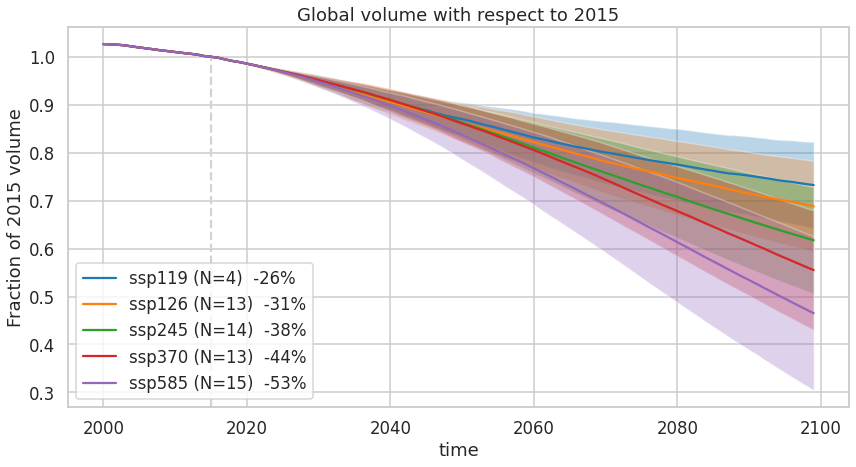

In [44]:
sns.set_context('talk')
global_out_frac =  global_out.divide(global_out.loc[2015])
plt.figure(figsize=(14, 7))
for ssp in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:  # , 'ssp434', 'ssp460', 'ssp534-over'
    sel_c = [c for c in global_out.columns if ssp in c]
    avg = global_out_frac[sel_c].mean(axis=1).loc[:2100]
    std = global_out_frac[sel_c].std(axis=1).loc[:2100]
    
    print(ssp + ':', '{}%'.format(int((avg.loc[2099]-1)*100)))
    avg.loc[2100] = np.NaN
    avg.loc[2300] = np.NaN
    plt.fill_between(avg.index, avg-std, avg+std, alpha=0.3)
    avg.plot(label=ssp + ' (N={})'.format(len(sel_c)) + '  {}%'.format(int((avg.loc[2099]-1)*100)))
y0, y1 = plt.gca().get_ylim()
plt.vlines(2015, ymin=y0, ymax=1, color='lightgray', linestyles='--');
plt.ylabel('Fraction of 2015 volume')
plt.ylim([y0, y1])
plt.title('Global volume with respect to 2015')
plt.legend();

ssp119: -26%
ssp126: -31%
ssp245: -38%
ssp370: -44%
ssp534-over: -42%
ssp585: -53%


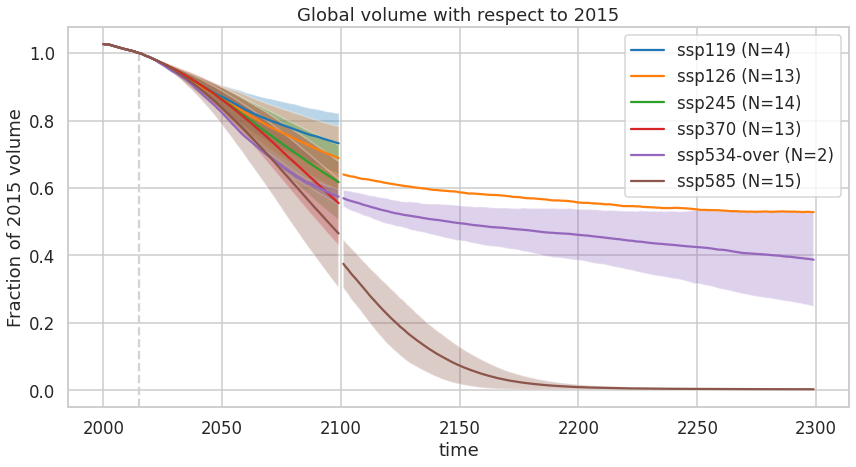

In [45]:
sns.set_context('talk')
global_out_frac =  global_out.divide(global_out.loc[2015])
plt.figure(figsize=(14, 7))
for ssp in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp534-over', 'ssp585']:  # , 'ssp434', 'ssp460', 'ssp534-over'
    sel_c = [c for c in global_out.columns if ssp in c]
    avg = global_out_frac[sel_c].mean(axis=1)#.loc[:2100]
    std = global_out_frac[sel_c].std(axis=1)#.loc[:2100]
    
    print(ssp + ':', '{}%'.format(int((avg.loc[2099]-1)*100)))
    avg.loc[2100] = np.NaN
    avg.loc[2300] = np.NaN
    plt.fill_between(avg.index, avg-std, avg+std, alpha=0.3)
    avg.plot(label=ssp + ' (N={})'.format(len(sel_c)))# + '  {}%'.format(int((avg.loc[2099]-1)*100)))
y0, y1 = plt.gca().get_ylim()
plt.vlines(2015, ymin=y0, ymax=1, color='lightgray', linestyles='--');
plt.ylabel('Fraction of 2015 volume')
plt.ylim([y0, y1])
plt.title('Global volume with respect to 2015')
plt.legend();

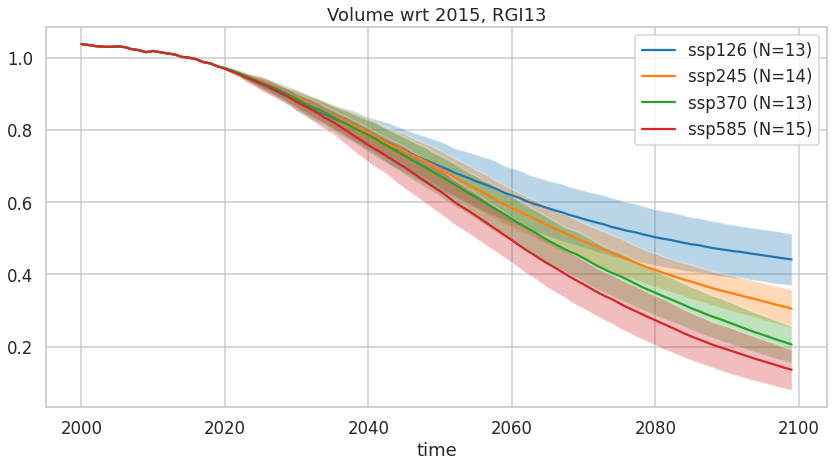

In [49]:
rgi_reg = '13'

plt.figure(figsize=(14, 7))
for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    frac = pd.read_csv('/home/users/fmaussion/run_scripts/run_cmip6/agg_for_ipcc/frac_output/{}/{}.csv'.format(rgi_reg, ssp), index_col=0)
    avg = frac.mean(axis=1).loc[:2100]
    std = frac.std(axis=1).loc[:2100]
    
    avg.loc[2100] = np.NaN
    avg.loc[2300] = np.NaN
    plt.fill_between(avg.index, avg-std, avg+std, alpha=0.3)
    avg.plot(label=ssp + ' (N={})'.format(len(frac.columns)));
plt.title('Volume wrt 2015, RGI' + rgi_reg)
plt.legend();

### Write frac bsl

In [55]:
tot_vol = pd.DataFrame()
tot_vol_bsl = pd.DataFrame()
for rgi_reg in range(1, 20):
    rgi_reg = '{:02d}'.format(rgi_reg)
    print(rgi_reg, flush=True)
    odir_frac = './agg_for_ipcc/frac_bsl_output/' + rgi_reg + '/'
    odir_abs_bsl = './agg_for_ipcc/abs_bsl_output/' + rgi_reg + '/'
    utils.mkdir(odir_frac, reset=True)
    utils.mkdir(odir_abs_bsl, reset=True)
    for ssp in out_all_ncs[rgi_reg].keys():
        odf_frac = pd.DataFrame()
        odf_bsl = pd.DataFrame()
        for gcm, nc in out_all_ncs[rgi_reg][ssp].items():
            if type(nc) == collections.defaultdict:
                continue
            frac_bsl = (nc.volume_bsl / nc.volume).to_series()
            if len(frac_bsl) > len(odf_frac):
                odf_frac = odf_frac.reindex(frac_bsl.index)  
                odf_bsl = odf_bsl.reindex(frac_bsl.index)  
            if len(frac_bsl) > len(tot_vol):
                tot_vol = tot_vol.reindex(frac_bsl.index)  
                tot_vol_bsl = tot_vol_bsl.reindex(frac_bsl.index)  
            odf_frac[gcm] = frac_bsl
            odf_bsl[gcm] = nc.volume_bsl.to_series()
            
            key_both = ssp + '_' + gcm
            
            if key_both not in tot_vol:
                tot_vol[key_both] = nc.volume.to_series()
                tot_vol_bsl[key_both] = nc.volume_bsl.to_series()
            else:
                tot_vol[key_both] += nc.volume.to_series()
                tot_vol_bsl[key_both] += nc.volume_bsl.to_series()
            
        odf_frac.to_csv(odir_frac + ssp + '.csv')
        odf_bsl.to_csv(odir_abs_bsl + ssp + '.csv')
tot_vol_bsl.to_csv('./agg_for_ipcc/abs_bsl_output/global.csv')
tot_vol_frac = tot_vol_bsl / tot_vol
tot_vol_frac.to_csv('./agg_for_ipcc/frac_bsl_output/global.csv')

01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
16
17
18
19


In [56]:
tot_vol.loc[2000].max() / (158*1e12), tot_vol.loc[2015].max() / (158*1e12)

(0.9889391558448608, 0.9633970125188861)

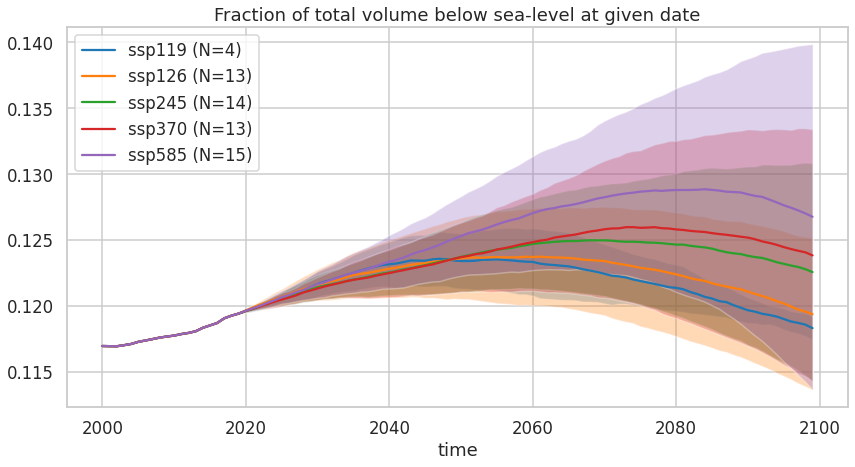

In [57]:
plt.figure(figsize=(14, 7))
frac_vol = tot_vol_frac
for ssp in ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:
    sel_c = [c for c in frac_vol.columns if ssp in c]
    
    avg = frac_vol[sel_c].mean(axis=1).loc[:2100]
    std = frac_vol[sel_c].std(axis=1).loc[:2100]
    
    avg.loc[2100] = np.NaN
    avg.loc[2300] = np.NaN
    plt.fill_between(avg.index, avg-std, avg+std, alpha=0.3)
    avg.plot(label=ssp + ' (N={})'.format(len(sel_c)));
plt.title('Fraction of total volume below sea-level at given date')
plt.legend(loc='upper left');